# Tutorial: Post-Estimations

**Author: Tianyu Du (tianyudu@stanford.edu)**

This tutorial covers the toolkit in `torch-choice` for visualizing and analyzing models after model estimation.

**Note**: models demonstrated in this tutorial are for demonstration purpose only, hence we don't estimate them in this tutorial. Instead, this tutorial focuses on APIs to visualize and analyze models.

In [1]:
# import required dependencies.
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

from torch_choice.data import ChoiceDataset, JointDataset, utils
from torch_choice.model import ConditionalLogitModel, NestedLogitModel
from torch_choice.utils.run_helper import run

In [2]:
# let's get a helper
def print_dict_shape(d):
    for key, val in d.items():
        if torch.is_tensor(val):
            print(f'dict.{key}.shape={val.shape}')

## Creating  `ChoiceDataset` Object

We first create a dummy `ChoiceDataset` object, please refer to the **data management** tutorial for more details.

In [3]:
# Feel free to modify it as you want.
num_users = 100
num_items = 25
num_sessions = 500

length_of_dataset = 10000
# create observables/features, the number of parameters are arbitrarily chosen.
# generate 128 features for each user, e.g., race, gender.
user_obs = torch.randn(num_users, 128)
# generate 64 features for each user, e.g., quality.
item_obs = torch.randn(num_items, 64)
# generate 10 features for each session, e.g., weekday indicator. 
session_obs = torch.randn(num_sessions, 10)
# generate 12 features for each session user pair, e.g., the budget of that user at the shopping day.
itemsession_obs = torch.randn(num_sessions, num_items, 12)
item_index = torch.LongTensor(np.random.choice(num_items, size=length_of_dataset))
user_index = torch.LongTensor(np.random.choice(num_users, size=length_of_dataset))
session_index = torch.LongTensor(np.random.choice(num_sessions, size=length_of_dataset))
# assume all items are available in all sessions.
item_availability = torch.ones(num_sessions, num_items).bool()

# initialize a ChoiceDataset object.
dataset = ChoiceDataset(
    # pre-specified keywords of __init__
    item_index=item_index,  # required.
    # optional:
    num_users=num_users,
    num_items=num_items,
    user_index=user_index,
    session_index=session_index,
    item_availability=item_availability,
    # additional keywords of __init__
    user_obs=user_obs,
    item_obs=item_obs,
    session_obs=session_obs,
    itemsession_obs=itemsession_obs)

In [4]:
print(dataset)

ChoiceDataset(label=[], item_index=[10000], user_index=[10000], session_index=[10000], item_availability=[500, 25], user_obs=[100, 128], item_obs=[25, 64], session_obs=[500, 10], itemsession_obs=[500, 25, 12], device=cpu)


# Conditional Logit Model

Suppose that we are creating a very complicated dummy model as the following. Please note that model and dataset here are for demonstration purpose only, the model is unlikely to converge if one estimate it on this dataset.

$$
U_{uis} = \alpha + \beta_i + \gamma_u + \delta_i^\top \textbf{x}^{(user)}_u + \eta^\top \textbf{y}^{(item)}_i + \theta_u^\top \textbf{z}^{(session)}_{s} + \kappa_i^\top \textbf{w}^{(itemsession)}_{is} + \iota_u^\top \textbf{w}^{(itemsession)}_{is} + \epsilon_{uis}
$$

In [5]:
model = ConditionalLogitModel(formula='(1|constant) + (1|item) + (1|user) + (user_obs|item) + (item_obs|constant) + (session_obs|user) + (itemsession_obs|item) + (itemsession_obs|user)',
                              dataset=dataset,
                              num_users=num_users,
                              num_items=num_items)

# estimate the model... omitted in this tutorial.

In [6]:
model

ConditionalLogitModel(
  (coef_dict): ModuleDict(
    (intercept[constant]): Coefficient(variation=constant, num_items=25, num_users=100, num_params=1, 1 trainable parameters in total, device=cpu).
    (intercept[item]): Coefficient(variation=item, num_items=25, num_users=100, num_params=1, 24 trainable parameters in total, device=cpu).
    (intercept[user]): Coefficient(variation=user, num_items=25, num_users=100, num_params=1, 100 trainable parameters in total, device=cpu).
    (user_obs[item]): Coefficient(variation=item, num_items=25, num_users=100, num_params=128, 3072 trainable parameters in total, device=cpu).
    (item_obs[constant]): Coefficient(variation=constant, num_items=25, num_users=100, num_params=64, 64 trainable parameters in total, device=cpu).
    (session_obs[user]): Coefficient(variation=user, num_items=25, num_users=100, num_params=10, 1000 trainable parameters in total, device=cpu).
    (itemsession_obs[item]): Coefficient(variation=item, num_items=25, num_users

## Retrieving Model Parameters with the `get_coefficient()` method.

In the model representation above, we can see that the model has coefficients from `intercept[constant]` to `itemsession_obs`. 
The `get_coefficient()` method allows users to retrieve the coefficient values from the model using the general syntax `model.get_coefficient(COEFFICIENT_NAME)`.

For example, `model.get_coefficient('intercept[constant]')` will return the value of $\alpha$, which is a scalar.

In [7]:
model.get_coefficient('intercept[constant]')

tensor([0.3743])

`model.get_coefficient('intercept[user]')` returns the array of $\gamma_u$'s, which is a 1D array of length `num_users`.

In [8]:
model.get_coefficient('intercept[user]').shape

torch.Size([100, 1])

`model.get_coefficient('session_obs[user]')` returns the corresponding coefficient $\theta_u$, which is a 2D array of shape `(num_users, num_session_features)`. Each row of the returned tensor corresponds to the coefficient vector of a user.

In [9]:
model.get_coefficient('session_obs[user]').shape

torch.Size([100, 10])

Lastly, the `itemsession_obs` (a 12-dimensional feature vector for each $(i, s)$ pairs) affects the utility through both $\kappa_i$ and $\iota_u$. For each item (except for the first item indexed with `0`, all coefficients of it are `0`), the `get_coefficient()` method returns a 2D array of shape `(num_items-1, num_itemsession_features)`.

The first row of the returned tensor corresponds to the coefficient vector of the **second** item, and so on.

`model.get_coefficient('itemsession_obs[user]')` provides the user-specific relationship between utility and item-session observables, $\iota_u$, which is a 2D array of shape `(num_users, num_itemsession_features)`. Each row of the returned tensor corresponds to the coefficient vector of a user.

In [10]:
model.get_coefficient('itemsession_obs[item]').shape

torch.Size([24, 12])

In [11]:
model.get_coefficient('itemsession_obs[user]').shape

torch.Size([100, 12])

## Visualizing Model Parameters
Researchers can use any plotting library to visualize the model parameters. Here we use `matplotlib` to demonstrate how to visualize the model parameters.

For example, we can plot the distribution of user fixed effect $\gamma_u$'s as the following.

1. Researcher can use the `get_coefficient()` method to retrieve the coefficient values. 

In [12]:
gamma = model.get_coefficient('intercept[user]')

2. After estimating the model with GPU, the coefficient values are stored in the GPU memory. We need move the coefficient values to CPU memory and convert it to a numpy array before plotting.

In [13]:
gamma = gamma.cpu().numpy()

3. The tensor of individual fixed effects has shape (num_users, 1), you can use `squeeze()` to remove the dimension of size 1. Since we haven't updated the model in this tutorial, the coefficient values are all zeros.

In [14]:
gamma = gamma.squeeze()
gamma

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

4. Researcher can use `matplotlib` to plot the distribution of the coefficient values. For example, the distribution plot of coefficients is helpful to identify potential groups of users with different preferences.

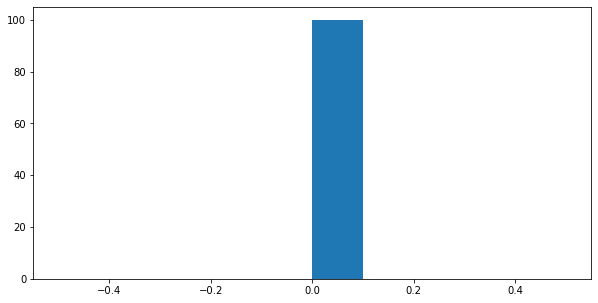

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(gamma)
plt.show()

# Nested Logit Model
The nested logit model has a very similar interface for coefficient extraction to the conditional logit model demonstrated above.

Consider a nested logit model with the same item-level model but with nest-level model incorporating user-fixed effect, category-fixed effect (specified by `(1|item)` in the `nest_formula`), and user-specific coefficient on a 64-dimensional nest-specific observable (specified by `(item_obs|user)` in the `nest_formula`).

The only difference is researcher would need to retrieve the coefficients of the nested logit model using the `get_coefficient()` method with the `level` argument.

## `NestedLogitModel.get_coefficient()` Method.

In [16]:
nest_to_item = {
    0: [0, 1, 2, 3, 4],
    1: [5, 6, 7, 8, 9],
    2: [10, 11, 12, 13, 14],
    3: [15, 16, 17, 18, 19],
    4: [20, 21, 22, 23, 24]
}

nest_dataset = ChoiceDataset(item_index=item_index, user_index=user_index, num_items=len(nest_to_item), num_users=num_users, item_obs=torch.randn(len(nest_to_item), 64))
joint_dataset = JointDataset(nest=nest_dataset, item=dataset)
joint_dataset

No `session_index` is provided, assume each choice instance is in its own session.


JointDataset with 2 sub-datasets: (
	nest: ChoiceDataset(label=[], item_index=[10000], user_index=[10000], session_index=[10000], item_availability=[], item_obs=[5, 64], device=cpu)
	item: ChoiceDataset(label=[], item_index=[10000], user_index=[10000], session_index=[10000], item_availability=[500, 25], user_obs=[100, 128], item_obs=[25, 64], session_obs=[500, 10], itemsession_obs=[500, 25, 12], device=cpu)
)

In [17]:
nested_model = NestedLogitModel(nest_to_item=nest_to_item,
                                nest_formula='(1|user) + (1|item) + (item_obs|user)',
                                item_formula='(1|constant) + (1|item) + (1|user) + (user_obs|item) + (item_obs|constant) + (session_obs|user) + (itemsession_obs|item) + (itemsession_obs|user)',
                                num_users=num_users,
                                dataset=joint_dataset,
                                shared_lambda=False)
nested_model


NestedLogitModel(
  (nest_coef_dict): ModuleDict(
    (intercept[user]): Coefficient(variation=user, num_items=5, num_users=100, num_params=1, 100 trainable parameters in total, device=cpu).
    (intercept[item]): Coefficient(variation=item, num_items=5, num_users=100, num_params=1, 4 trainable parameters in total, device=cpu).
    (item_obs[user]): Coefficient(variation=user, num_items=5, num_users=100, num_params=64, 6400 trainable parameters in total, device=cpu).
  )
  (item_coef_dict): ModuleDict(
    (intercept[constant]): Coefficient(variation=constant, num_items=25, num_users=100, num_params=1, 1 trainable parameters in total, device=cpu).
    (intercept[item]): Coefficient(variation=item, num_items=25, num_users=100, num_params=1, 24 trainable parameters in total, device=cpu).
    (intercept[user]): Coefficient(variation=user, num_items=25, num_users=100, num_params=1, 100 trainable parameters in total, device=cpu).
    (user_obs[item]): Coefficient(variation=item, num_items=2

In [18]:
# estimate the model... omitted in this tutorial.

For example, you can use the following code snippet to retrieve the coefficient of the user-fixed effect in the nest level model, which is a vector with `num_users` elements.

In [19]:
nested_model.get_coefficient('intercept[user]', level='nest').shape

torch.Size([100, 1])

Similarly, by changing to `level='item'`, the researcher can obtain the coefficient of user-specific fixed effect in the item level model, which is a also vector with `num_users` elements.

In [20]:
nested_model.get_coefficient('intercept[user]', level='item').shape

torch.Size([100, 1])

This API generalizes to all other coefficients listed above such as `itemsession_obs[item]` and `itemsession_obs[user]`.

One exception is the coefficients for inclusive values, (often denoted as $\lambda$). Researchers can retrieve the coefficient of the inclusive value by using `get_coefficient('lambda')` without specifying the `level` argument (`get_coefficient` will disregard any `level` argument if the coefficient name is `lambda`). The returned value is a scalar if `shared_lambda` is `True`, and a 1D array of length `num_nests` if `shared_lambda` is `False`. In our case, the returned value is an array of length five (we have five nests in this model).

In [21]:
nested_model.get_coefficient('lambda')

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000])